# 선박 제어

두개의 추진장비를 가진 선박 최적 경로 구현

In [1]:
import math

import imageio
import IPython
import gymnasium as gym
import numpy as np
import pygame
from pygame import gfxdraw
from PIL import Image
import tqdm

In [2]:
COLOR_BLACK = 0, 0, 0
COLOR_WHITE = 255, 255, 255
COLOR_RED = 255, 0, 0


class ShipControl(gym.Env):
    def __init__(self, radius=0.05):
        super().__init__()
        self.radius = radius
        self.speed = 0.05  # 목적지 반경
        self.rotation_speed = 0.1  # 회전 속도
        self.max_steps = 1000  # 최대 스텝 수
        self.action_space = gym.spaces.Discrete(3)  # 0: 왼쪽 엔진만 1: 오른쪽 엔진만 2: 둘다
        # 웨이포인트와 장애물의 좌표
        self.waypoint_coordinates = [(0.7, 0.7), (0.7, -0.7), (-0.7, 0.7), (-0.7, -0.7)]
        self.obstacle_coordinates = [(0, 0.7), (0, -0.7), (-0.7, 0), (0.7, 0)]
        # 관찰 공간 정의
        # x, y, 각도, 웨이포인트, 장애물
        self.observation_space = gym.spaces.Dict(
            {
                'x': gym.spaces.Box(low=-1, high=1, shape=(1,)),
                'y': gym.spaces.Box(low=-1, high=1, shape=(1,)),
                'angle': gym.spaces.Box(low=0, high=1, shape=(1,)),
                'waypoints': gym.spaces.MultiBinary(4),
                'obstacles': gym.spaces.MultiBinary(4),
            }
        )

    def reset(self, seed=None):
        self.steps = 0
        self.x = np.random.uniform(-0.5, 0.5)
        self.y = np.random.uniform(-0.5, 0.5)
        self.angle = np.random.uniform(0, 1)
        random_number = np.random.randint(1, 16)
        self.waypoints = list(map(int, bin(random_number)[2:].zfill(4)))
        random_number = np.random.randint(1, 16)
        self.obstacles = list(map(int, bin(random_number)[2:].zfill(4)))
        return self.obs, {}
    
    @property
    def obs(self):
        return {'x': np.array([self.x]), 
                'y': np.array([self.y]), 
                'angle': np.array([self.angle]), 
                 'waypoints': np.array(self.waypoints), 
                 'obstacles': np.array(self.obstacles)
               }
    
    def step(self, action):
        self.steps += 1
        move = 0
        if action == 0:  # 왼쪽 엔진만
            self.angle += self.rotation_speed  # 오른쪽으로 회전
            move = self.speed / 2 # 속도의 절반
        elif action == 1: # 오른쪽 엔진만
            self.angle -= self.rotation_speed # 왼쪽으로 회전
            move = self.speed / 2 # 속도의 절반
        elif action == 2: # 양쪽 엔진
            move = self.speed # 전진
        self.angle -= self.angle // 1 # 0과 1 사이로 각도를 제한
        direction = self.rad - math.pi / 2 # 0도가 위쪽이므로 90도를 빼줌
        self.x += math.cos(direction) * move # 코사인 값이 x축 이동
        self.y += math.sin(direction) * move # 사인 값이 y축 이동
        
        reward = -1 # 보상
        new_waypoints = [] # 새로운 웨이포인트
        for w, (wx, wy) in zip(self.waypoints, self.waypoint_coordinates):
            if w == 1 and np.sqrt((self.x - wx) ** 2 + (self.y - wy)**2) < self.radius:
                # 웨이포인트에 반경 이내로 도달하면 보상을 100으로 설정하고 웨이포인트 지움
                w = 0
                reward = 100
            new_waypoints.append(w)
        self.waypoints = new_waypoints
        
        terminated = False
        truncated = False
        for w, (wx, wy) in zip(self.obstacles, self.obstacle_coordinates):
            if w == 1 and np.sqrt((self.x - wx) ** 2 + (self.y - wy)**2) < 0.05:
                # 장애물에 반경 이내로 도달하면 보상을 -1000으로 설정하고 종료
                terminated = True
                reward = -1000
        
        if sum(new_waypoints) == 0:
            # 모든 웨이포인트를 지나면 종료
            terminated = True
        elif np.abs(self.x) > 1 or np.abs(self.y) > 1:
            # 화면 밖으로 나가면 종료
            terminated = True
            reward = -1000
        elif self.steps >= self.max_steps:
            # 최대 스텝 수를 넘으면 종료
            truncated = True

        return self.obs, reward, terminated, truncated, {}
        
    @property
    def rad(self):
        # 각도를 라디안으로 변환
        return 2 * math.pi * self.angle
    
    def render(self):
        # 화면에 그리기
        ship_length = 40
        ship_width = 20
        engine_length = 10
        engine_width = 5
        screen_width = 600
        screen_height = 600

        # 배경
        surf = pygame.Surface((screen_width, screen_height))
        # 파란색 배경
        surf.fill((0, 128, 255))
        
        # 배의 화면 좌표
        screen_x = screen_width / 2 + self.x * (screen_width / 2)
        screen_y = screen_height / 2 + self.y * (screen_height / 2)

        # 배를 그림
        ship = -ship_width / 2, ship_width / 2, -ship_length / 2, ship_length / 2, (0, 0, 0)
        left_engine = (
            -ship_width / 2 - engine_width, 
            -ship_width / 2, 
            ship_length / 2-engine_length / 2, 
            ship_length / 2+engine_length / 2, 
            COLOR_WHITE)
        right_engine = (
            ship_width / 2, 
            ship_width / 2 + engine_width, 
            ship_length / 2-engine_length / 2, 
            ship_length / 2+engine_length / 2, 
            COLOR_RED)

        for left, right, tail, head, color in [ship, left_engine, right_engine]:
            coords = []
            for c in [(left, head), (left, tail), (right, tail), (right, head)]:
                c = pygame.math.Vector2(c).rotate_rad(self.rad)  # 회전
                coords.append((c[0] + screen_x, c[1] + screen_y))  # 각 점의 좌표
            gfxdraw.aapolygon(surf, coords, color)
            gfxdraw.filled_polygon(surf, coords, color)
        
        # 웨이포인트와 장애물을 그림
        r = int(self.radius * screen_width / 2)
        for w, (wx, wy) in zip(self.waypoints, self.waypoint_coordinates):
            if w == 1:
                gfxdraw.filled_circle(surf, int(300 + 300 * wx) , int(300 + 300 * wy), r, COLOR_WHITE)
        for w, (wx, wy) in zip(self.obstacles, self.obstacle_coordinates):
            if w == 1:
                gfxdraw.filled_circle(surf, int(300 + 300 * wx) , int(300 + 300 * wy), 15, COLOR_BLACK)
        arr = np.transpose(np.array(pygame.surfarray.pixels3d(surf)), axes=(1, 0, 2))
        return arr

In [5]:
def render_episode(env, model, max_frame=1000):
    state, _ = env.reset()
    frames = []
    done = False
    for _ in tqdm.trange(max_frame): # 최대 프레임까지 진행
        action, _state = model.predict(state, deterministic=True)
        next_state, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
        state = next_state
        frames.append(env.render())  # 프레임을 수집
    imageio.mimsave('cartpole.gif', frames, fps=30) # 초당 30프레임으로 GIF 만들기
    return IPython.display.Image('cartpole.gif') # GIF 보기



In [4]:
env = ShipControl(radius=0.7)

 12%|████████▉                                                                     | 115/1000 [00:00<00:03, 282.46it/s]


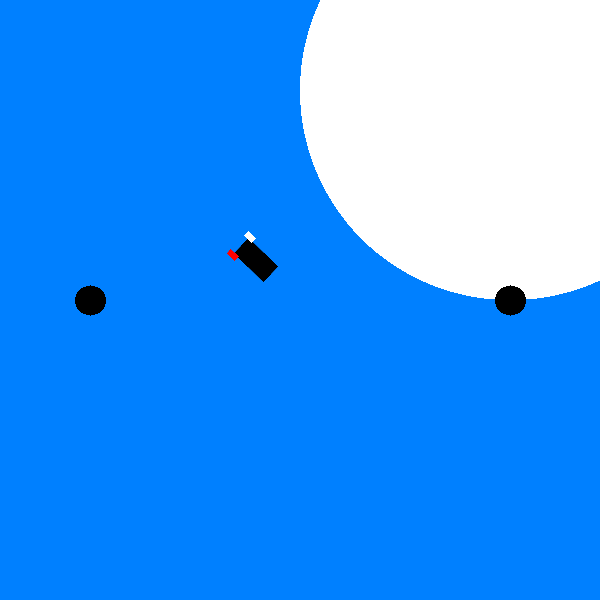

In [7]:
class RandomModel:
    def predict(self, state, **kwargs):
        return env.action_space.sample(), None
render_episode(env, RandomModel())

In [8]:
# 모델
from stable_baselines3 import DQN
model = DQN("MultiInputPolicy", env, verbose=1)

C:\Users\eupho\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [9]:
# 총 1000회에 걸쳐  학습
model.learn(total_timesteps=100_000, log_interval=4, progress_bar=True)

Output()

  1%|█                                                                               | 13/1000 [00:00<00:33, 29.67it/s]


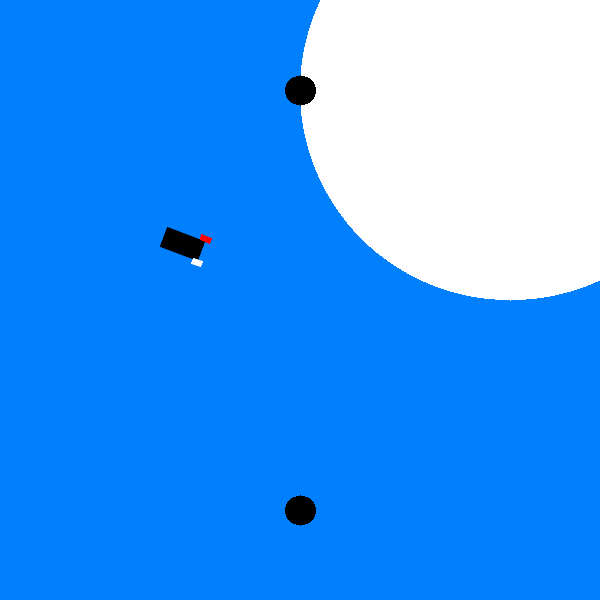

In [10]:
render_episode(env, model)